In [2]:
!pip install mediapipe
!pip install rembg

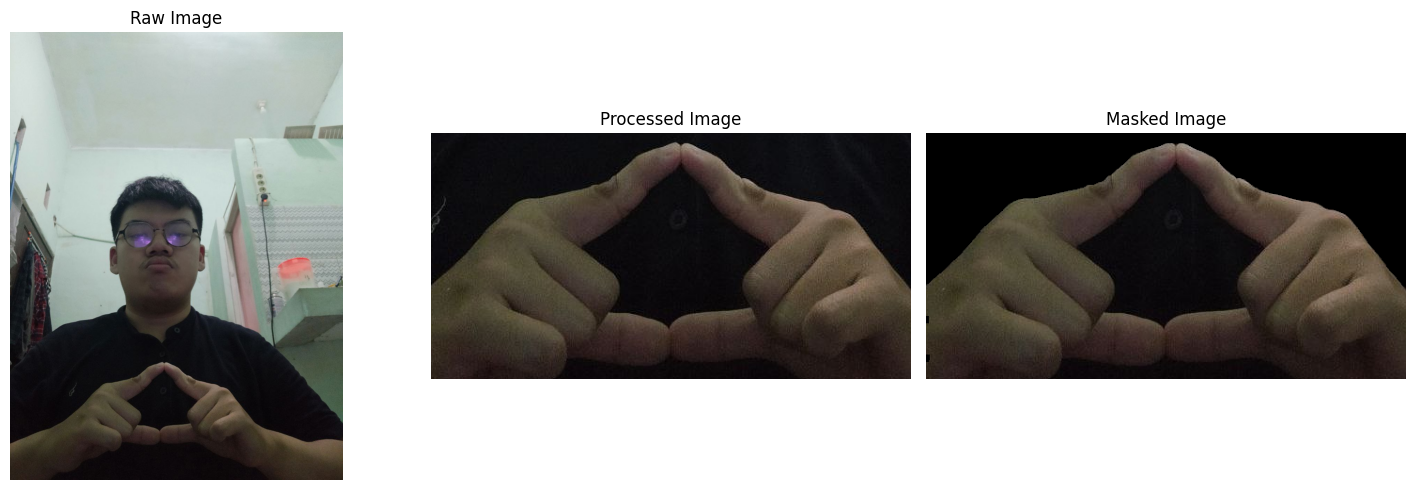

In [15]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

HAND_DETECTION_THRESHOLD = 0.5

def detect_and_process_hands(image):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=HAND_DETECTION_THRESHOLD)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)

    if not results.multi_hand_landmarks:
        print("Tidak ada tangan terdeteksi")
        return None, None, None

    height, width, _ = image.shape
    all_hand_landmarks = []

    for hand_landmarks in results.multi_hand_landmarks:
        landmarks = []
        for landmark in hand_landmarks.landmark:
            x, y = int(landmark.x * width), int(landmark.y * height)
            landmarks.append((x, y))
        all_hand_landmarks.append(landmarks)

    x_min = min(min(landmark[0] for landmark in hand) for hand in all_hand_landmarks)
    y_min = min(min(landmark[1] for landmark in hand) for hand in all_hand_landmarks)
    x_max = max(max(landmark[0] for landmark in hand) for hand in all_hand_landmarks)
    y_max = max(max(landmark[1] for landmark in hand) for hand in all_hand_landmarks)

    padding = 20
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(width, x_max + padding)
    y_max = min(height, y_max + padding)

    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cropped_hand = image[y_min:y_max, x_min:x_max]

    mask = np.zeros(cropped_hand.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    rect = (1, 1, cropped_hand.shape[1]-1, cropped_hand.shape[0]-1)
    cv2.grabCut(cropped_hand, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    kernel = np.ones((5,5), np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)

    cropped_hand_without_background = cropped_hand * mask2[:,:,np.newaxis]

    cropped_hand_without_background = cropped_hand_without_background + np.full(cropped_hand.shape, 0, dtype=np.uint8) * (1 - mask2[:,:,np.newaxis])

    return image_with_box, cropped_hand, cropped_hand_without_background

def plot_comparison(raw_image, processed_image, masked_image):
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
    plt.title('Raw Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title('Processed Image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title('Masked Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_and_display_image(input_path):
    image = cv2.imread(input_path)

    result_image, cropped_hand, cropped_hand_without_background = detect_and_process_hands(image)

    if result_image is not None:
        plot_comparison(image, cropped_hand, cropped_hand_without_background)
    else:
        print("No hand detected in the image.")

input_image_path = "/content/A (1).jpg"
process_and_display_image(input_image_path)

In [18]:
import qrcode

qrcode.make("https://colab.research.google.com/drive/1-GEJmSGmqg0aaWZrfst6IlDS0rpT6Dkl?usp=sharing").save("qrcode.png")